<p><h1>Capstone Project</h1>
<h2>Introduction</h2>
<h4>The question I've chosen to answer is: "Which is more important: the number of nearby schools or the lack of competitors to table-top and trading card game store?"</h4>
<br>
<span>
As a board game, trading card game enthusiast myself; I’ve seen stores close within a year of opening to some that stand the test of time. The people who frequent these stores are very diverse and possess diverse interests.
<br>
<br>
My audience is a store owner. My analysis will target younger audiences by focusing on venue to school data. I will use Foursquare data for Vancouver BC in Canada in my analysis. My analysis will use a combination of regression and Kmeans clustering.
I predict that the best location to open wont be an area with few or no similar stores, but one that is relatively near to a relevant venue (school) and not to far from the largest cluster of players.
</span>
<h2>Data Description</h2>
<ul>
  <li>What are the board game stores in the area?</li>
    <ul>
      <li>Foursquare doesn't have a category for this type of store, so I'll need to search from similar stores and manually clean for the correct stores. The endpoint "listed" may be useful to find more venues.</li>
    </ul>
    <ul>
      <li>where are they located?</li>
      <li>how many schools are within walking distance?</li>
      <li>how many similar venues are nearby?</li>
    <li>how many tips?</li>
    <li>how many likes?</li>
    </ul>
    </ul>
</ul>
<h4>Endpoints</h4>
<ul>
        <li>search</li>
        <li>likes</li>
        <li>listed</li>
        <li>tips</li>
        <li>venuecheckins – was scrapped due to authorization issues</li>        

</p>

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Map library
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.datasets.samples_generator import make_blobs
print('Libraries imported.')

Solving environment: ...working... 
  - anaconda/win-64::openssl-1.1.1d-he774522_2
  - defaults/win-64::openssl-1.1.1d-he774522_2done

# All requested packages already installed.

Solving environment: ...working... 
  - anaconda/win-64::openssl-1.1.1d-he774522_2
  - defaults/win-64::openssl-1.1.1d-he774522_2done

# All requested packages already installed.

Libraries imported.


In [2]:
CLIENT_ID = 'UGNMOUILBAJEYW3YYS2HASIB442ZI3KJQT3SFUDCHBZCL2WO' # your Foursquare ID
CLIENT_SECRET = 'IJCTKK2QMTXQ5FMNE0NN4UYJ0EELTAYVVHMCV4XPZSSZKKNQ' # your Foursquare Secret
VERSION = '20180604'

In [3]:
address = 'vancouver , BC'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

49.2608724 -123.1139529


<h3>Target Venues</h3>
<span>

In [4]:
# pulls the foursquare data
search_query = 'Hobbies'
radius = 70811.1
LIMIT = 50
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

In [5]:
# Cleaning data

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
#drop unneeded columns
dataframe_filtered.drop(inplace=True, columns=['address','categories','labeledLatLngs','cc','city','state','country','distance','formattedAddress','crossStreet','neighborhood'])
venues=dataframe_filtered

<h3>Number of Nearby Schools</h3>

In [6]:
#pull location data for target venues
lat = venues['lat']
lng = venues['lng']
#concatenate for queries
ll =  lat.astype(str) +','+ lng.astype(str)
#create list to hold data
n_schools=[]

In [7]:
#search parameters for schools
radius = 800
LIMIT = 50
search_query = 'school'
#for loop to pull data
for x in ll:
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, x, VERSION,search_query, radius, LIMIT)
    results = requests.get(url).json()
    # tranform venues into a dataframe
    dataframe = json_normalize(results['response']['venues'])
    # count number of rows and return to list
    n_schools.append(len(dataframe.index))
#add data to primary dataframe
venues['schools'] = n_schools

<h3>Number of likes for target venues</h3>

In [8]:
#create a list to hold likes data
likes = []
#grab the venue id into an object to iterate through
vid = venues['id']
#for loop to pull data
for x in vid:
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(x, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    #add data to list
    likes.append(results['response']['likes']['count'])
#add data to primary dataframe
venues['likes']=likes

<h3>Number of Tips for Target Venues</h3>

In [9]:
#create a list to hold tips data
tips = []
#grab the venue id into an object to iterate through
vid = venues['id']
#for loop to pull data
for x in vid:
    url = 'https://api.foursquare.com/v2/venues/{}/tips?&client_id={}&client_secret={}&v={}'.format(x, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    #add data to list
    tips.append(results['response']['tips']['count'])
#add data to primary dataframe
venues['tips'] = tips

<h3>Checkins</h3>
<span>Unfortunately, user checkins are only available to the user themselves. Will have to use limited like data for analysis.</span>

In [10]:
url= 'https://api.foursquare.com/v2/users/289926/checkins?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
results = requests.get(url).json()
results

{'meta': {'code': 401,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing oauth_token. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5eb9d32902a172001b484a06'},
 'response': {}}

<h3>Processing Missing and Duplicate Data</h3>

In [11]:
venues

,name,lat,lng,postalCode,id,schools,likes,tips
0,Strategies Games & Hobbies,49.250560,-123.100601,V5V 3N9,4ab5435ff964a520a27320e3,7,4,2
1,Gacha Hobbies & Toys,49.184235,-123.133207,V6X 4J7,4bc8c43c12bdb7132dfc3c94,4,3,2
2,Magic Box Hobbies,49.238527,-123.155476,V6M 1N9,4d4c835be1ec6dcbe735da75,1,1,1
3,Go Go Hobbies & Toys Ltd,49.249026,-122.836172,V3K 3R8,4c4dde4f1b8e1b8d2c0e4f26,3,2,3
4,Grand Prix Hobbies,49.264050,-123.173024,NaN,4e2b370c8877b69d49de2536,7,0,0
5,Central Hobbies,49.258263,-123.046342,V5M 2E1,4d1155d56360a35d37cf8988,6,3,2
6,Imperial Hobbies,49.180345,-123.151884,V6X 2C7,4bf99b4ab182c9b6863d795a,3,3,2
7,Racing Devil Hobbies,49.183656,-123.133847,V6X 4J7,5039774ce4b0e2a7db0b7702,4,0,0
8,Burnaby Hobbies,49.214925,-122.988193,NaN,4ebdaef902d5a63a3e264ba8,3,0,0
9,Burnaby Hobbies,49.214854,-122.987869,V5J 2B7,56b00853498ea562c0c5ae31,3,0,0


In [12]:
#to suppress anaconda's warning about writing over data
import warnings
warnings.filterwarnings('ignore')

<span>First, some postal codes are missing. I'll manually add those back in.</span>

In [13]:
venues['postalCode'][4]='V5M 2E1'
venues['postalCode'][13]='V3H 2C5'
venues['postalCode'][14]='V3M 4K1'
venues

,name,lat,lng,postalCode,id,schools,likes,tips
0,Strategies Games & Hobbies,49.250560,-123.100601,V5V 3N9,4ab5435ff964a520a27320e3,7,4,2
1,Gacha Hobbies & Toys,49.184235,-123.133207,V6X 4J7,4bc8c43c12bdb7132dfc3c94,4,3,2
2,Magic Box Hobbies,49.238527,-123.155476,V6M 1N9,4d4c835be1ec6dcbe735da75,1,1,1
3,Go Go Hobbies & Toys Ltd,49.249026,-122.836172,V3K 3R8,4c4dde4f1b8e1b8d2c0e4f26,3,2,3
4,Grand Prix Hobbies,49.264050,-123.173024,V5M 2E1,4e2b370c8877b69d49de2536,7,0,0
5,Central Hobbies,49.258263,-123.046342,V5M 2E1,4d1155d56360a35d37cf8988,6,3,2
6,Imperial Hobbies,49.180345,-123.151884,V6X 2C7,4bf99b4ab182c9b6863d795a,3,3,2
7,Racing Devil Hobbies,49.183656,-123.133847,V6X 4J7,5039774ce4b0e2a7db0b7702,4,0,0
8,Burnaby Hobbies,49.214925,-122.988193,NaN,4ebdaef902d5a63a3e264ba8,3,0,0
9,Burnaby Hobbies,49.214854,-122.987869,V5J 2B7,56b00853498ea562c0c5ae31,3,0,0


<span> Burnaby Hobbies and Apollo Hobbies appears to be duplicated, so I'll remove the rows 9 and 21. "Hobbies" also appears to blank, so I'll remove row 18.</span>

In [14]:
drop = ['4ebdaef902d5a63a3e264ba8','4e78f2d062e1b76aa3edc34f', '4c15256482a3c9b63557fef8']
for x in drop:
    venues = venues[venues['id']!=x]

<span>Imperial Hobbies and BC Shaver & Hobbies have only one store each, but the foursquare includes two venues with different data. I will combine these two entires by adding likes and tips. The true locations appear to be row 7 and 20, so I am dropping row 10 and 21's school data.</span>

In [15]:
venues[venues['likes'] == '4bf99b4ab182c9b6863d795a']='4'
venues[venues['likes'] == '5d167ca752b6b100233c91b5']='5'
drop = ['5d167ca752b6b100233c91b5','4e324133483bf02b1f880c98']
for x in drop:
    venues = venues[venues['id']!=x]
venues

,name,lat,lng,postalCode,id,schools,likes,tips
0,Strategies Games & Hobbies,49.2506,-123.101,V5V 3N9,4ab5435ff964a520a27320e3,7,4,2
1,Gacha Hobbies & Toys,49.1842,-123.133,V6X 4J7,4bc8c43c12bdb7132dfc3c94,4,3,2
2,Magic Box Hobbies,49.2385,-123.155,V6M 1N9,4d4c835be1ec6dcbe735da75,1,1,1
3,Go Go Hobbies & Toys Ltd,49.249,-122.836,V3K 3R8,4c4dde4f1b8e1b8d2c0e4f26,3,2,3
4,Grand Prix Hobbies,49.2641,-123.173,V5M 2E1,4e2b370c8877b69d49de2536,7,0,0
5,Central Hobbies,49.2583,-123.046,V5M 2E1,4d1155d56360a35d37cf8988,6,3,2
6,Imperial Hobbies,49.1803,-123.152,V6X 2C7,4bf99b4ab182c9b6863d795a,3,3,2
7,Racing Devil Hobbies,49.1837,-123.134,V6X 4J7,5039774ce4b0e2a7db0b7702,4,0,0
9,Burnaby Hobbies,49.2149,-122.988,V5J 2B7,56b00853498ea562c0c5ae31,3,0,0
11,Apollo Hobbies,49.2541,-122.919,V5A 1X3,4cd8b49a2a80548186909d2c,3,0,0


<h4>Reviewing data on map</h4>

In [16]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="vc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

<span>For some unknown reason, venues far outside vancouver were added to the dataset. I'll remove any store south of the Fraser River (southern arm).</span>

In [17]:
# create map using latitude and longitude values
map_vc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(venues['lat'], venues['lng'], venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vc)  
    
map_vc

In [18]:
drop = ['4d50d3d9e02754817cc2a4b6','4f2d8fcce4b0124ab89cfc4a', '4c6acab08e7c0f47fe18e30f', '4e0b9b7dc65b977a208758d2']
for x in drop:
    venues = venues[venues['id']!=x]

In [19]:
venues

,name,lat,lng,postalCode,id,schools,likes,tips
0,Strategies Games & Hobbies,49.2506,-123.101,V5V 3N9,4ab5435ff964a520a27320e3,7,4,2
1,Gacha Hobbies & Toys,49.1842,-123.133,V6X 4J7,4bc8c43c12bdb7132dfc3c94,4,3,2
2,Magic Box Hobbies,49.2385,-123.155,V6M 1N9,4d4c835be1ec6dcbe735da75,1,1,1
3,Go Go Hobbies & Toys Ltd,49.249,-122.836,V3K 3R8,4c4dde4f1b8e1b8d2c0e4f26,3,2,3
4,Grand Prix Hobbies,49.2641,-123.173,V5M 2E1,4e2b370c8877b69d49de2536,7,0,0
5,Central Hobbies,49.2583,-123.046,V5M 2E1,4d1155d56360a35d37cf8988,6,3,2
6,Imperial Hobbies,49.1803,-123.152,V6X 2C7,4bf99b4ab182c9b6863d795a,3,3,2
7,Racing Devil Hobbies,49.1837,-123.134,V6X 4J7,5039774ce4b0e2a7db0b7702,4,0,0
9,Burnaby Hobbies,49.2149,-122.988,V5J 2B7,56b00853498ea562c0c5ae31,3,0,0
11,Apollo Hobbies,49.2541,-122.919,V5A 1X3,4cd8b49a2a80548186909d2c,3,0,0


In [20]:
venues.set_index('id', inplace = True)

In [21]:
# create map of New York using latitude and longitude values
map_vc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(venues['lat'], venues['lng'], venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vc)  
map_vc

<h4>Converting Categorical Data</h4>
I'll need the postal code data converted to numerical data. I'll use the frequency of each postal code.

In [22]:
postal_data = []
for x in venues['postalCode']:
    postal_data.append(len(venues[venues['postalCode'] == x]))
venues['postaldata'] = postal_data
postal_data

[1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1]

In [23]:
data= venues.drop(columns=['postalCode'])
data

,name,lat,lng,schools,likes,tips,postaldata
id,,,,,,,
4ab5435ff964a520a27320e3,Strategies Games & Hobbies,49.2506,-123.101,7,4,2,1
4bc8c43c12bdb7132dfc3c94,Gacha Hobbies & Toys,49.1842,-123.133,4,3,2,2
4d4c835be1ec6dcbe735da75,Magic Box Hobbies,49.2385,-123.155,1,1,1,1
4c4dde4f1b8e1b8d2c0e4f26,Go Go Hobbies & Toys Ltd,49.249,-122.836,3,2,3,1
4e2b370c8877b69d49de2536,Grand Prix Hobbies,49.2641,-123.173,7,0,0,2
4d1155d56360a35d37cf8988,Central Hobbies,49.2583,-123.046,6,3,2,2
4bf99b4ab182c9b6863d795a,Imperial Hobbies,49.1803,-123.152,3,3,2,1
5039774ce4b0e2a7db0b7702,Racing Devil Hobbies,49.1837,-123.134,4,0,0,2
56b00853498ea562c0c5ae31,Burnaby Hobbies,49.2149,-122.988,3,0,0,1


<h3>Analysis</h3>
<span>Before analysis, I'll drop the columns not being used.</span>

In [24]:
data

,name,lat,lng,schools,likes,tips,postaldata
id,,,,,,,
4ab5435ff964a520a27320e3,Strategies Games & Hobbies,49.2506,-123.101,7,4,2,1
4bc8c43c12bdb7132dfc3c94,Gacha Hobbies & Toys,49.1842,-123.133,4,3,2,2
4d4c835be1ec6dcbe735da75,Magic Box Hobbies,49.2385,-123.155,1,1,1,1
4c4dde4f1b8e1b8d2c0e4f26,Go Go Hobbies & Toys Ltd,49.249,-122.836,3,2,3,1
4e2b370c8877b69d49de2536,Grand Prix Hobbies,49.2641,-123.173,7,0,0,2
4d1155d56360a35d37cf8988,Central Hobbies,49.2583,-123.046,6,3,2,2
4bf99b4ab182c9b6863d795a,Imperial Hobbies,49.1803,-123.152,3,3,2,1
5039774ce4b0e2a7db0b7702,Racing Devil Hobbies,49.1837,-123.134,4,0,0,2
56b00853498ea562c0c5ae31,Burnaby Hobbies,49.2149,-122.988,3,0,0,1


In [25]:
test=data.drop(columns=['name', 'lat', 'lng'])
test

,schools,likes,tips,postaldata
id,,,,
4ab5435ff964a520a27320e3,7,4,2,1
4bc8c43c12bdb7132dfc3c94,4,3,2,2
4d4c835be1ec6dcbe735da75,1,1,1,1
4c4dde4f1b8e1b8d2c0e4f26,3,2,3,1
4e2b370c8877b69d49de2536,7,0,0,2
4d1155d56360a35d37cf8988,6,3,2,2
4bf99b4ab182c9b6863d795a,3,3,2,1
5039774ce4b0e2a7db0b7702,4,0,0,2
56b00853498ea562c0c5ae31,3,0,0,1


<h4>Multiple Linear Regression</h4>
<span>Regression is an analysis method for determining the relationship between variables. Linear Regression attempts to create a straight vector through the data. The distance between the predicted vector data and each true data point is minimized. Think of the linear graphs from back in math class, the "y = b + mx". That's what linear regression is trying to do. In the case of multiple linear regression, it would be "y = b + m1x1 + m2x2" or 
<br>
<br>
"likes/tips = intercept + m1(number of nearby schools) + m2(number of similar venues in the same postal area)."</span>

In [26]:
regr = linear_model.LinearRegression()
x = np.asanyarray(test[['schools','postaldata']])
y = np.asanyarray(test[['likes','tips']])
regr.fit (x, y)
# The coefficients
print ('Intercept', regr.intercept_)
print ('Coefficients for likes: ', regr.coef_[0])
print ('Coefficients for tips: ', regr.coef_[1])

Intercept [0.64444444 0.647343  ]
Coefficients for likes:  [ 0.4        -0.62222222]
Coefficients for tips:  [ 0.17391304 -0.28019324]


What about the relationship between tips and likes?
<h4>Tips</h4>

In [27]:
x = np.asanyarray(test[['likes', 'postaldata', 'schools']])
y = np.asanyarray(test[['tips']])
regr.fit (x, y)
# The coefficients
print ('Intercept', regr.intercept_)
print ('Coefficients for likes: ', regr.coef_)

Intercept [0.20053688]
Coefficients for likes:  [[ 0.69331984  0.15120577 -0.10341489]]


<h4>Likes</h4>

In [28]:
x = np.asanyarray(test[['tips', 'postaldata', 'schools']])
y = np.asanyarray(test[['likes']])
regr.fit (x, y)
# The coefficients
print ('Intercept', regr.intercept_)
print ('Coefficients for tips: ', regr.coef_)

Intercept [-0.05844245]
Coefficients for tips:  [[ 1.08580289 -0.31798759  0.21116471]]


Based on the regression analysis, one should be wary of the strength between likes to tips. I'll combine these two columns into one value. If left alone, this would have shewed results.

In [29]:
test['likes_tips'] = test['likes'] + test['tips']
test = test.drop(columns=['likes', 'tips'])
test

,schools,postaldata,likes_tips
id,,,
4ab5435ff964a520a27320e3,7,1,6
4bc8c43c12bdb7132dfc3c94,4,2,5
4d4c835be1ec6dcbe735da75,1,1,2
4c4dde4f1b8e1b8d2c0e4f26,3,1,5
4e2b370c8877b69d49de2536,7,2,0
4d1155d56360a35d37cf8988,6,2,5
4bf99b4ab182c9b6863d795a,3,1,5
5039774ce4b0e2a7db0b7702,4,2,0
56b00853498ea562c0c5ae31,3,1,0


In [30]:
x = np.asanyarray(test[['schools','postaldata']])
y = np.asanyarray(test[['likes_tips']])
regr.fit (x, y)
# The coefficients
print ('Intercept', regr.intercept_)
print ('Coefficients Final: ', regr.coef_)

Intercept [1.29178744]
Coefficients Final:  [[ 0.57391304 -0.90241546]]


<h4>KMeans</h4>
<span>KMeans Clustering is an unsupervised machine learning algorithm. The algorithm places data into a given number of clusters ("k") around central points. The average distance between the clustered data and the centroids, distortion, is minimized.
<br>
Choosing the "k" value is important. A higher "k" will always reduce distortion, but the effect is weaker at values. A popular method to choose "k" is called the "elbow method." Numerous iterations of the algorithm are ran and the amount of distortion is recorded and graphed. The "k" value that reduces the greatest amount of distortion before diminishing returns.</span>

In [31]:
distortions = [] 
inertias = [] 
mapping = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(test) 
    kmeanModel.fit(test)     
      
    distortions.append(sum(np.min(cdist(test, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / test.shape[0]) 
  
    mapping[k] = sum(np.min(cdist(test, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / test.shape[0]

In [32]:
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val))

1 : 2.9563265174574007
2 : 1.5447185943613317
3 : 1.2043262427101167
4 : 0.8447693744263304
5 : 0.6101777848700943
6 : 0.5024524963927768
7 : 0.3692178188874786
8 : 0.2241702740286996
9 : 0.07692307692307693


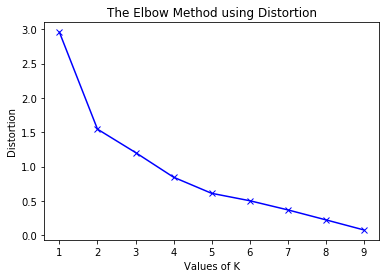

In [33]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Two appears to be where the elbow occurs. I'll re-run the algorithm and review the results.

In [34]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(test)

# save cluster center information
kmeanModel_cluster_centers = kmeanModel.cluster_centers_

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [35]:
data['cluster'] = kmeanModel.labels_
data

,name,lat,lng,schools,likes,tips,postaldata,cluster
id,,,,,,,,
4ab5435ff964a520a27320e3,Strategies Games & Hobbies,49.2506,-123.101,7,4,2,1,1
4bc8c43c12bdb7132dfc3c94,Gacha Hobbies & Toys,49.1842,-123.133,4,3,2,2,1
4d4c835be1ec6dcbe735da75,Magic Box Hobbies,49.2385,-123.155,1,1,1,1,0
4c4dde4f1b8e1b8d2c0e4f26,Go Go Hobbies & Toys Ltd,49.249,-122.836,3,2,3,1,1
4e2b370c8877b69d49de2536,Grand Prix Hobbies,49.2641,-123.173,7,0,0,2,0
4d1155d56360a35d37cf8988,Central Hobbies,49.2583,-123.046,6,3,2,2,1
4bf99b4ab182c9b6863d795a,Imperial Hobbies,49.1803,-123.152,3,3,2,1,1
5039774ce4b0e2a7db0b7702,Racing Devil Hobbies,49.1837,-123.134,4,0,0,2,0
56b00853498ea562c0c5ae31,Burnaby Hobbies,49.2149,-122.988,3,0,0,1,0


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data['lat'], data['lng'], data['name'], data['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

<h4>Cluster 1</h4>

In [37]:
print('Cluster Center: ' + str(kmeanModel_cluster_centers[0]))
print('Mean schools: ' + str(data[data['cluster'] == 0]['schools'].mean()))
print('Mean postaldata: ' + str(data[data['cluster'] == 0]['postaldata'].mean()))
data[data['cluster'] == 0]

Cluster Center: [3.125 1.25  0.375]
Mean schools: 3.125
Mean postaldata: 1.25


,name,lat,lng,schools,likes,tips,postaldata,cluster
id,,,,,,,,
4d4c835be1ec6dcbe735da75,Magic Box Hobbies,49.2385,-123.155,1,1,1,1,0
4e2b370c8877b69d49de2536,Grand Prix Hobbies,49.2641,-123.173,7,0,0,2,0
5039774ce4b0e2a7db0b7702,Racing Devil Hobbies,49.1837,-123.134,4,0,0,2,0
56b00853498ea562c0c5ae31,Burnaby Hobbies,49.2149,-122.988,3,0,0,1,0
4cd8b49a2a80548186909d2c,Apollo Hobbies,49.2541,-122.919,3,0,0,1,0
4b92fd7df964a520ff2c34e3,On Track Hobbies,49.2769,-122.839,3,0,0,1,0
4c42137c520fa593c3a6caac,SN Hobbies,49.2852,-122.823,2,1,0,1,0
4b944ac7f964a520407334e3,Seb's RC Shop,49.2665,-122.778,2,0,0,1,0


<h4>Cluster 2</h4>

In [38]:
print('Cluster center: ' + str(kmeanModel_cluster_centers[1]))
print('Mean schools: ' + str(data[data['cluster'] == 1]['schools'].mean()))
print('Mean postaldata: ' + str(data[data['cluster'] == 1]['postaldata'].mean()))
data[data['cluster'] == 1]

Cluster center: [4.6 1.4 5.2]
Mean schools: 4.6
Mean postaldata: 1.4


,name,lat,lng,schools,likes,tips,postaldata,cluster
id,,,,,,,,
4ab5435ff964a520a27320e3,Strategies Games & Hobbies,49.2506,-123.101,7,4,2,1,1
4bc8c43c12bdb7132dfc3c94,Gacha Hobbies & Toys,49.1842,-123.133,4,3,2,2,1
4c4dde4f1b8e1b8d2c0e4f26,Go Go Hobbies & Toys Ltd,49.249,-122.836,3,2,3,1,1
4d1155d56360a35d37cf8988,Central Hobbies,49.2583,-123.046,6,3,2,2,1
4bf99b4ab182c9b6863d795a,Imperial Hobbies,49.1803,-123.152,3,3,2,1,1


<h2>Conclusions</h2>

<span>The data is pretty limited. A difference of one like or tip would swing the concludes for a location in a completely different direction. Other important data points, such as what products are sold, are not represented in the data.</span>

<span>With the given data:</span>
<ul>
<li>Regression analysis shows that the number of nearby schools has a weaker impact on likes and tips than the number of other hobby stores within the same postal code.</li>
<li>The number of nearby schools has a positive impact. For about every two schools, one can expect a tip or like.</li>
<li>The number of venues within the same postal code has a negative impact. For each similar venue, one can expect one less tip or like (when otherwise expected). </li>
<li>The Kmeans clusters analysis has segmented the venues into high and low like/tips clusters. Given the regression analysis, this is expected as likes to tips has a strong impact. Still, the high like/tips cluster averages one more school. Again, as expected. The confounding piece of information is the nearby similar venues data. The high like/tips cluster averages slightly more nearby venues despite having a negative impact. This is likely due to the fact that there are so few venues compared to schools that the negative effect is overwhelmed.</li>
<li>There is a pretty glaring outlier in Cluster 1. Grand Prix Hobbies, despite being near to 7 schools, has no likes or tips. 7 nearby schools is the highest value in the dataset. Strategies Games & Hobbies also has 7 nearby schools, but has the most likes and tips. </li>
</ul>

<span>Fundamentally, there is not enough data to confidently support any conclusion on the impact of nearby schools or the number of nearby similar venues. However, the data does follow what one would expect: that having nearby schools is a positive effect while nearby competitors has a negative effect.</span>